[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)

# Unsupervised learning with Autoencoder

We first play with MNIST dataset and pieces of code seen during the course.

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline

## Loading MNIST

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

print('Using gpu: %s ' % torch.cuda.is_available())
print("Too old GPU so no cuda")

Using gpu: True 
Too old GPU so no cuda


In [14]:
# to be modified if not on colab
root_dir = './data/'
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=True, download=True, transform=transforms.ToTensor()),
    batch_size=256, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

## Helper Functions

In [15]:
def to_img(x):
    x = x.cpu().data.numpy()
    x = 0.5 * (x + 1)
    x = np.clip(x, 0, 1)
    x = x.reshape([-1, 28, 28])
    return x

def plot_reconstructions(model):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    The middle row is the encoded vector.
    The encoder is called by model.encoder
    The decoder is called by model.decoder
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    data = data.view([-1, 784])
    data.requires_grad = False
    data = data.to(device)
    true_imgs = data
    encoded_imgs = model.encoder(data)
    decoded_imgs = model.decoder(encoded_imgs)
    
    true_imgs = to_img(true_imgs)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

## Simple Auto-Encoder

We'll start with the simplest autoencoder: a single, fully-connected layer as the encoder and decoder.

In [16]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)

    def forward(self, x):
        encoded = F.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded

In [17]:
input_dim = 784
encoding_dim = 64

model = AutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

Why did we take 784 as input dimension?

To find the learning rate, see the documentation for [Adam optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).

In [18]:
def train_model(model,loss_fn,data_loader=None,epochs=1,optimizer=None):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view([-1, 784]).to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [19]:
train_model(model, loss_fn, data_loader=train_loader, epochs=10, optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.123324
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.045831
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.033600
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.030162
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.025554
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.021945
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.021482
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.020849
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.019725
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.019168
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.019179
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.018435
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.018210
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.017666
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.017353
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.018428
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.017980
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.017185
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.017258
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.015968
Train Epoch: 6 [51200/60000 (85%)]	

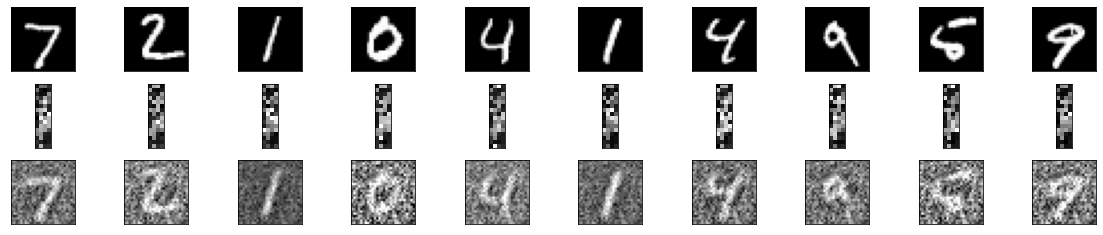

In [20]:
plot_reconstructions(model)

## 1. Exercise: Stacked Autoencoder

Now you will code an autoencoder where both the encoder and the decoder are multilayer perceptron (MLP). You can take for the encoder a first hidden layer with dimension 128, a second one with dimension 64 and then the code of dimension 32. For the decoder, you can take the same sequence of dimensions in reverse order.

In [119]:
class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DeepAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, 128), nn.ReLU(), nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, encoding_dim))
        self.decoder = nn.Sequential(nn.Linear(encoding_dim, 64), nn.ReLU(), nn.Linear(64, 128), nn.ReLU(), nn.Linear(128, input_dim))
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [120]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

In [121]:
train_model(model, loss_fn, data_loader=train_loader, epochs=10, optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.694315
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.255533
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.240481
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.221363
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.191097
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.168564
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.163401
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.151269
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.148804
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.150824
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.144249
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.148182
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.140480
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.133737
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.129512
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.126329
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.126182
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.121353
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.121355
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.121617
Train Epoch: 6 [51200/60000 (85%)]	

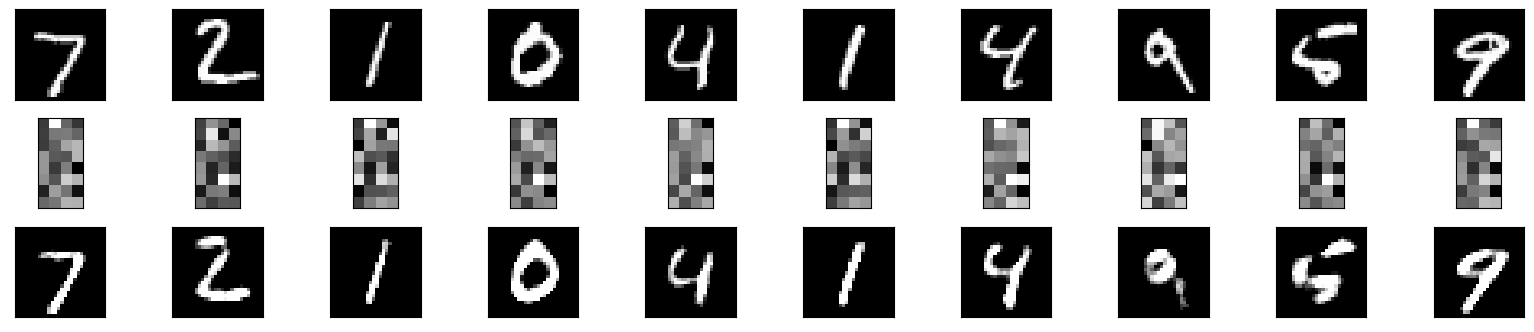

In [123]:
plot_reconstructions(model)

Replace the `MSELoss` with a `BCEWithLogitsLoss` for each pixel. Note the unusual use of `BCEWithLogitsLoss`! You can have a look at the definition of [Cross Entropy](https://en.wikipedia.org/wiki/Cross_entropy).

## 2. Optional

At this stage, you can code the interpolation described in the lesson to obtain:

![](https://raw.githubusercontent.com/dataflowr/slides/master/images/module9/interp_AE.png)

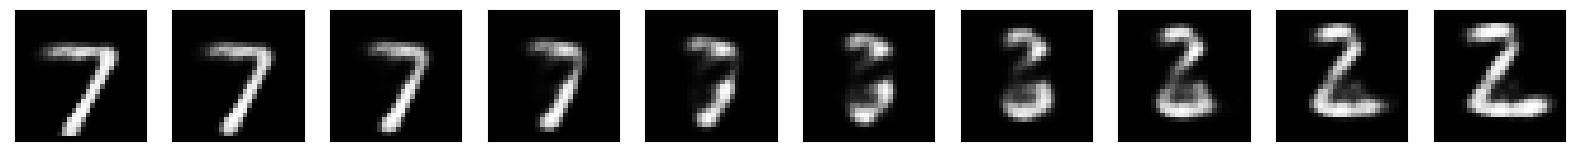

In [125]:
data, _ = next(iter(test_loader))
data = data.view([-1, 784])

encoded = model.encoder(data)

interpolation = [F.sigmoid(model.decoder(alpha * encoded[1] + (1 - alpha) * encoded[0])).view(28,28).detach() for alpha in np.linspace(0, 1, 10)]

fig, ax = plt.subplots(1, 10, figsize=(20, 5))
for k, im in enumerate(interpolation):
    ax[k].imshow(im)
    ax[k].get_xaxis().set_visible(False)
    ax[k].get_yaxis().set_visible(False)

# 3. Exercise: Implement a denoising AE:


Use previous code and with minimal modifications, transform your AE in a denoising AE. Now, you first apply some noise to your input and try to recover the original data at the output. For the noise, you can add some random noise or erase some of the pixels. In this last case, you should obtain something like: 

![](https://raw.githubusercontent.com/dataflowr/slides/master/images/module9/denoising_AE.png)

The first line corresponds to the original digit, the second line to the noisy version of the digit given as input to your network, the third line is the associated code and the last line is the denoised digit obtained by your decoder from the code.

In [189]:
torch.FloatTensor.uniform_?

In [192]:
torch.FloatTensor(10,10).uniform_

<function Tensor.uniform_>

In [182]:
# You need first to modify the training process by adding noise to your data
# Hint if you want to erase pixels: https://stackoverflow.com/questions/49216615/is-there-an-efficient-way-to-create-a-random-bit-mask-in-pytorch
def train_denoiser(model,loss_fn,data_loader=None,epochs=1,optimizer=None, noise=0.1):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view([-1, 784])
            noise_mask = torch.FloatTensor(data.shape).uniform_() > noise
            noisy_data = noise_mask * data
            optimizer.zero_grad()
            output = model(noisy_data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [183]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

In [184]:
train_denoiser(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer, noise=0.8)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.693036
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.263722
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.245170
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.244772
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.223739
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.204682
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.208628
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.194852
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.179037
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.185988
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.177924
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.176760
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.169210
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.168680
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.174654
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.171362
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.168511
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.167504
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.160981
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.161741
Train Epoch: 6 [51200/60000 (85%)]	

In [185]:
# Now you need to modify the plot function
def plot_denoising(model, noise=0.1):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, , the second row is the noisy digits, 
    the third row is the encoded vector and
    the bottom is the decoder reconstruction.
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    data = data.view([-1, 784])
    data.requires_grad = False
    
    true_imgs = data
    noise_mask = torch.FloatTensor(data.shape).uniform_() > noise
    noisy_data = noise_mask * data
    encoded_imgs = model.encoder(noisy_data)
    decoded_imgs = model.decoder(encoded_imgs)
    
    true_imgs = to_img(data)
    noisy_imgs = to_img(noisy_data)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display corrupted original
        ax = plt.subplot(4, n, i + 1 +n)
        plt.imshow(noisy_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display code
        ax = plt.subplot(4, n, i + 1 + 2*n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(4, n, i + 1 +  3*n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

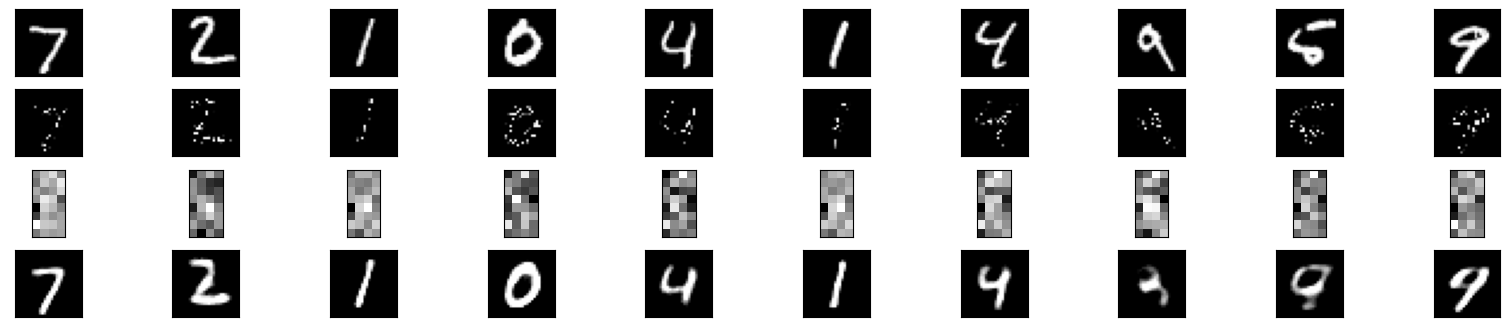

In [186]:
plot_denoising(model, noise=0.8)

# 4. Optional: how to deal with convolutions?

Hint: start by decreasing the size of your image with `Conv2d` by using a `stride` like:

In [ ]:
conv = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=2)
x = torch.randn(2, 8, 64, 64)
y = conv(x)
y.shape

Now use [transposed convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) (or [deconvolution](https://distill.pub/2016/deconv-checkerboard/)) with the same parameters:

In [ ]:
convt = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, padding=1, stride=2)

In [ ]:
convt(y).shape

To get the same size as `x`, play with `output_padding`.

Now, you have all the tools to build a convolutional autoencoder!

[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)